In [3]:
!pip install numpy pandas matplotlib torch scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.1 MB/s eta 0:00:0000:0100:12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 1.1 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 1.0 MB/s eta 0:00:0000:01m00:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 1.1 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 801.8 kB/s eta 0:00:0000:0100:26
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl (209.8 MB)
  Using cached nvidia_cuda_runtime_

In [4]:
import pandas as pd

### Loading dataset

In [5]:
df = pd.read_csv("xor.csv")
df.head()

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0


In [6]:
X = df[["x1", "x2"]].values
y = df["class label"].values

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True, stratify=y)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True, stratify=y_train)

In [9]:
print(f"Train size {X_train.shape}")
print(f"Validation size {X_val.shape}")
print(f"Test size {X_test.shape}")

Train size (573, 2)
Validation size (64, 2)
Test size (113, 2)


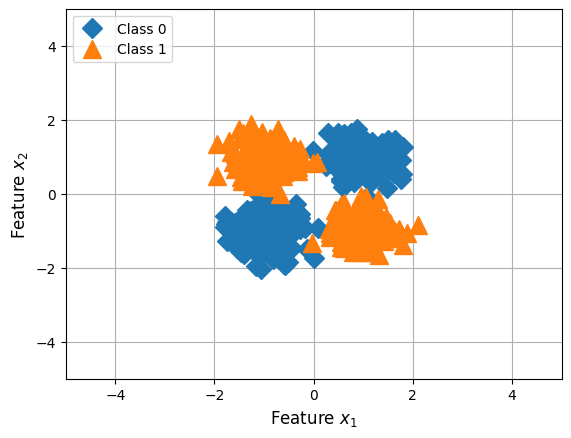

In [10]:
import matplotlib.pyplot as plt


plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

### Implement Model

In [11]:
import torch

class PyTorchMLP(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(

            # first hidden layer
            torch.nn.Linear(num_features, 25),
            torch.nn.ReLU(),

            # second hidden layer
            torch.nn.Linear(25, 15),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(15, num_classes),
        )


    def forward(self, x):
        logits = self.all_layers(x)
        return logits

### Define DataLoader

In [12]:
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return self.labels.shape[0]


train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=32,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=False,
)

### Training loop

In [13]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.inference_mode():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)


        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [14]:
import torch.nn.functional as F

torch.manual_seed(1)

model = PyTorchMLP(num_features=2, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
num_epochs = 10

for epoch in range(num_epochs):
    model = model.train()

    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch + 1:03d} / {num_epochs:03d}"
              f" | Batch {batch_idx:03d} / {len(train_loader):03d}"
              f" | Train/Val loss: {loss:2f}")

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train accuracy: {train_acc} | Val accuracy: {val_acc}")

/home/alexa/codingTime/dl_lightning_ai_course/venv/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 001 / 010 | Batch 000 / 018 | Train/Val loss: 0.687770
Epoch: 001 / 010 | Batch 001 / 018 | Train/Val loss: 0.673314
Epoch: 001 / 010 | Batch 002 / 018 | Train/Val loss: 0.690216
Epoch: 001 / 010 | Batch 003 / 018 | Train/Val loss: 0.674187
Epoch: 001 / 010 | Batch 004 / 018 | Train/Val loss: 0.658506
Epoch: 001 / 010 | Batch 005 / 018 | Train/Val loss: 0.674150
Epoch: 001 / 010 | Batch 006 / 018 | Train/Val loss: 0.652452
Epoch: 001 / 010 | Batch 007 / 018 | Train/Val loss: 0.682071
Epoch: 001 / 010 | Batch 008 / 018 | Train/Val loss: 0.670620
Epoch: 001 / 010 | Batch 009 / 018 | Train/Val loss: 0.674305
Epoch: 001 / 010 | Batch 010 / 018 | Train/Val loss: 0.668361
Epoch: 001 / 010 | Batch 011 / 018 | Train/Val loss: 0.666243
Epoch: 001 / 010 | Batch 012 / 018 | Train/Val loss: 0.667774
Epoch: 001 / 010 | Batch 013 / 018 | Train/Val loss: 0.660209
Epoch: 001 / 010 | Batch 014 / 018 | Train/Val loss: 0.655131
Epoch: 001 / 010 | Batch 015 / 018 | Train/Val loss: 0.670250
Epoch: 0

### Model evaluation

In [15]:
!pip install --upgrade matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('D', '^', 'x', 's', 'v')
    colors = ('C0', 'C1', 'C2', 'C3', 'C4')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    plt.figure()

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits = classifier.forward(tensor)
    Z = np.argmax(logits.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    #edgecolor='black',
                    marker=markers[idx],
                    label=cl)

ValueError: 'C0' is not a valid color value.

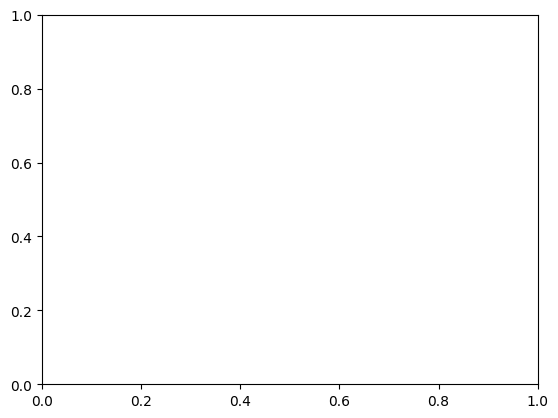

In [17]:
plot_decision_regions(X_train, y_train, classifier=model)